In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader 
import numpy as np
import os, shutil
import pandas, csv, json
import random
from datetime import datetime
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style({u'font.sans-serif':['simhei']})
plt.rcParams[u'font.sans-serif'] = ['simhei']
plt.rcParams['axes.unicode_minus'] = False
import pandas as pd
import scipy
import math
from scipy.stats import genextreme as gev, gumbel_r, norm, gompertz
from scipy.special import gamma, factorial

from constants import * 
from utils import *

In [2]:

args = ["--no=-1"]
# args = ["--no=-1", "--skip_site"]
opt = parse(args)
same_seeds(opt.seed)


陽明
all


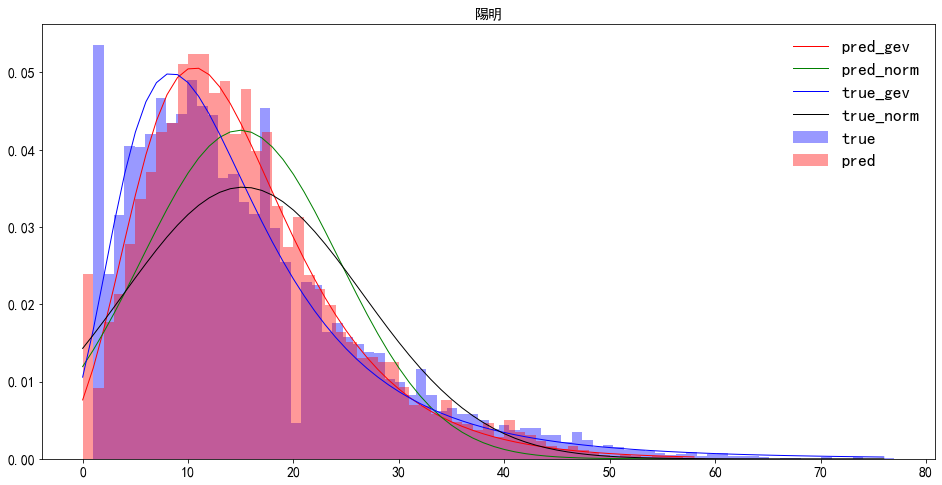

merged


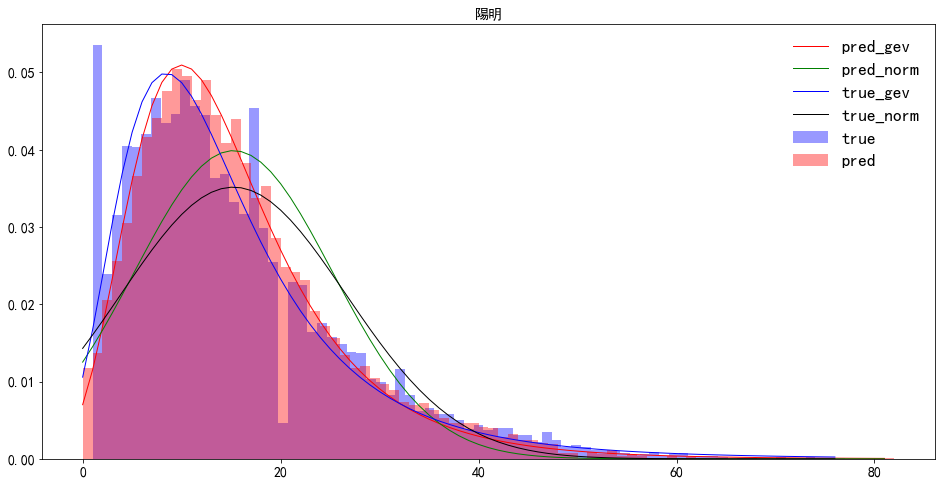

淡水
all


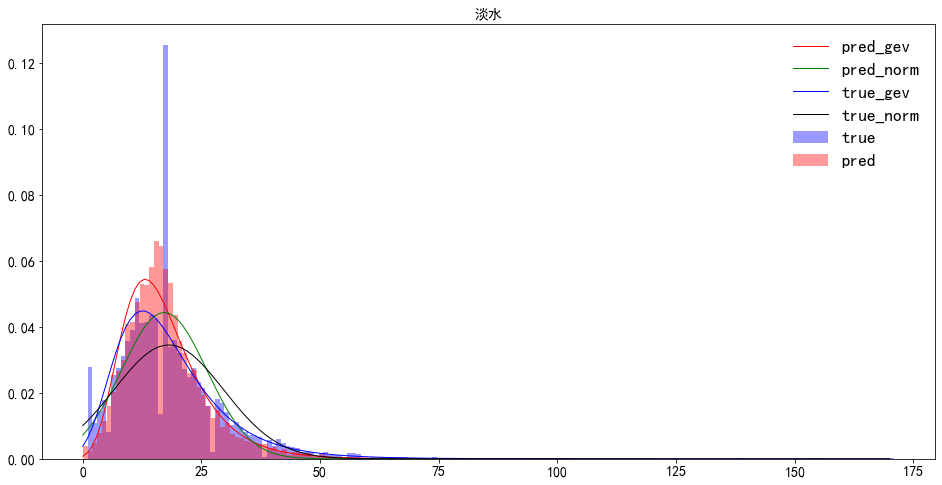

merged


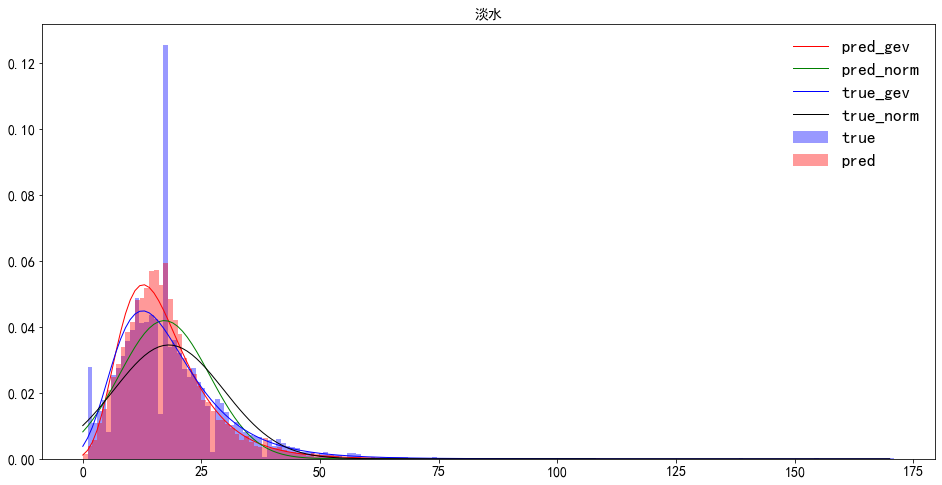

士林
all


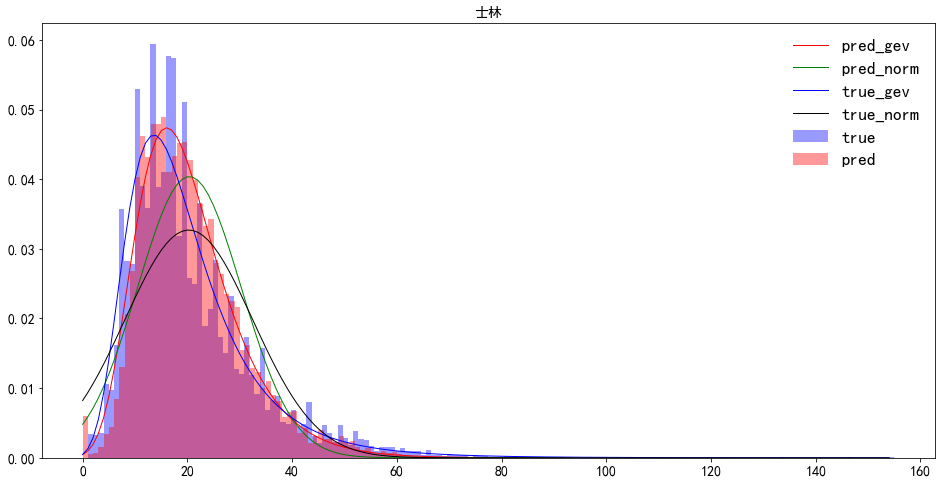

merged


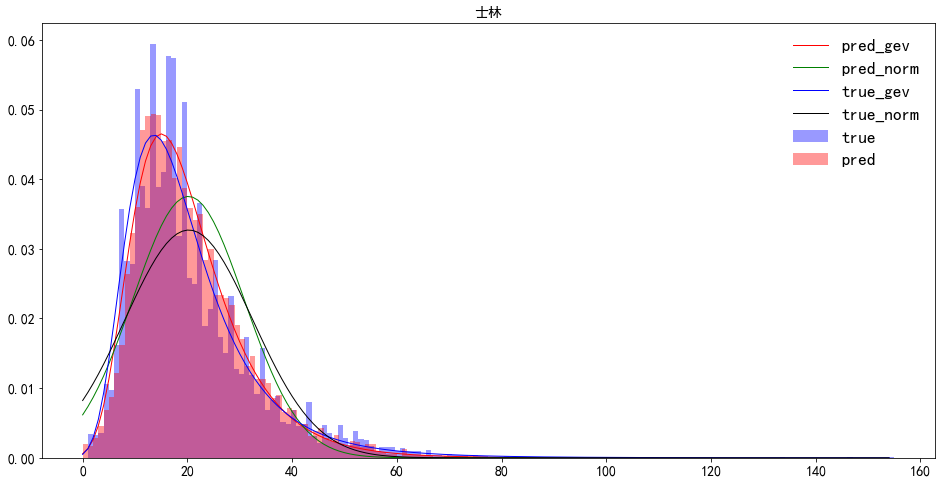

中山
all


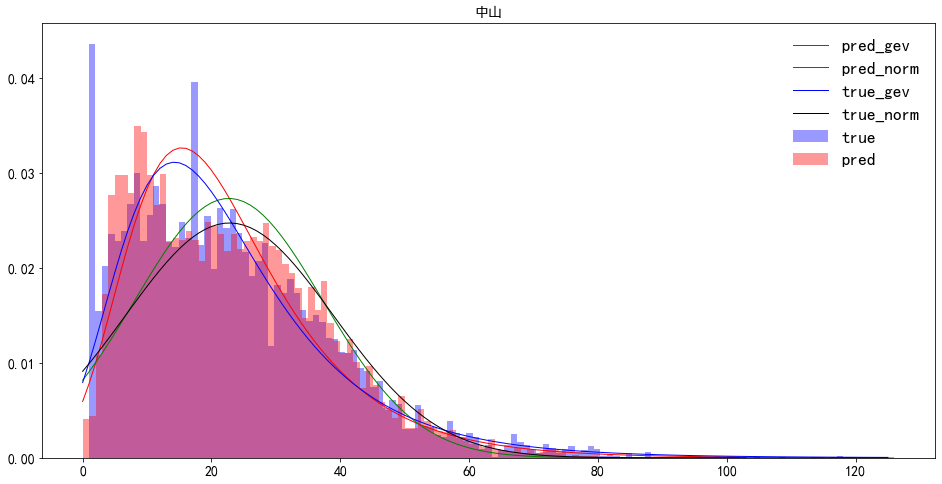

merged


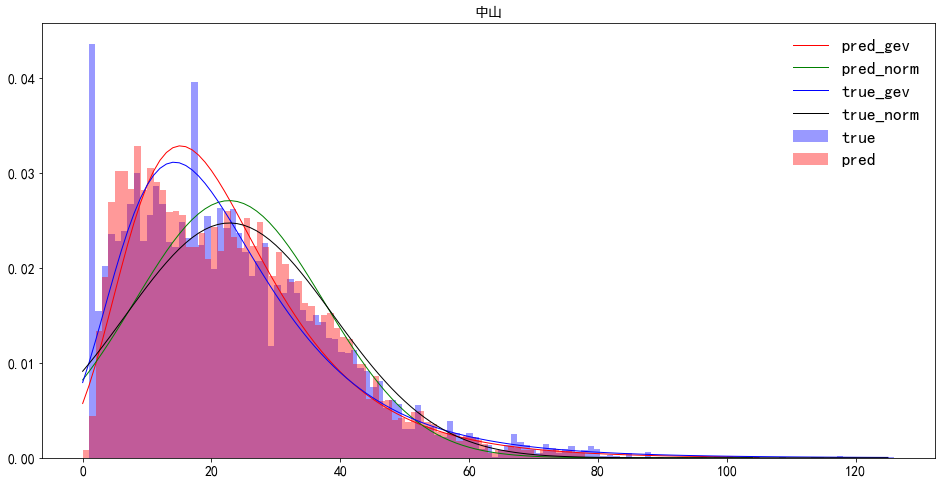

萬華
all


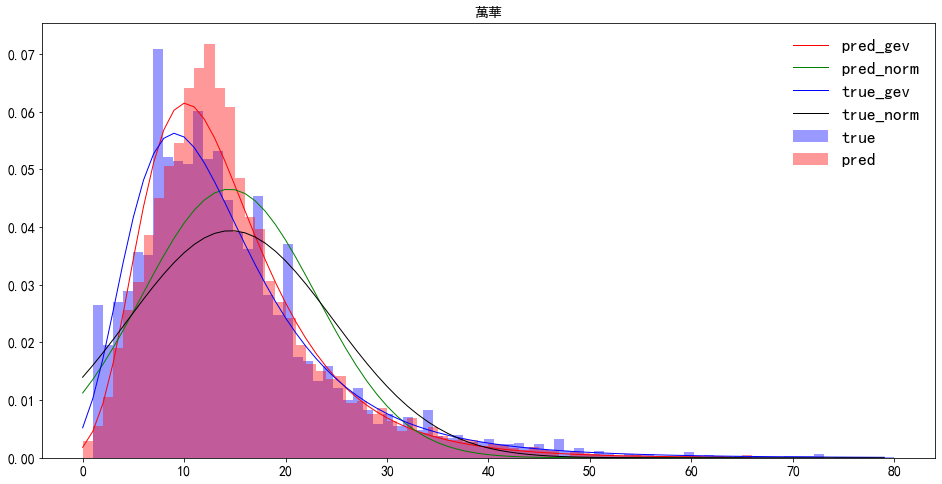

merged


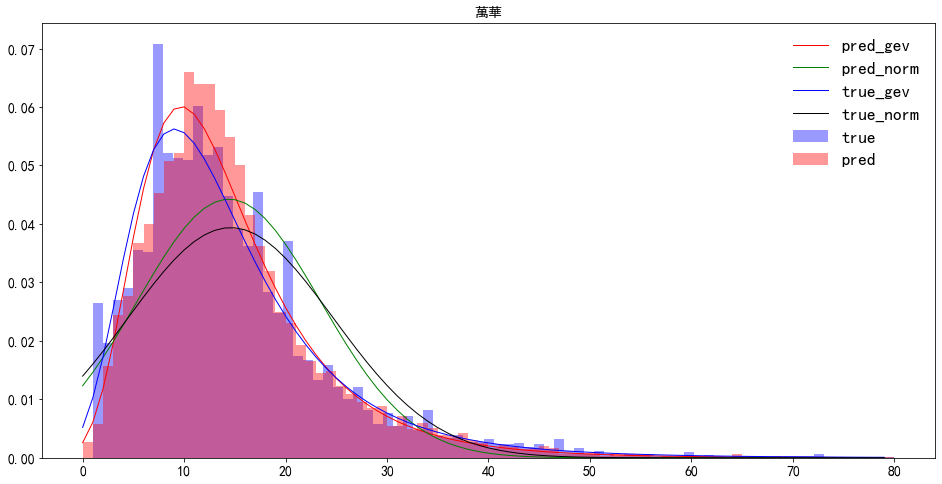

觀音
all


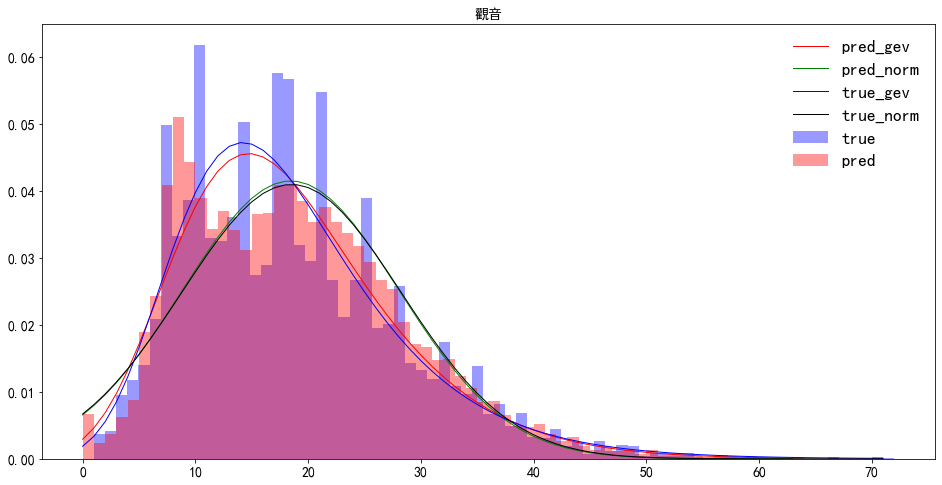

merged


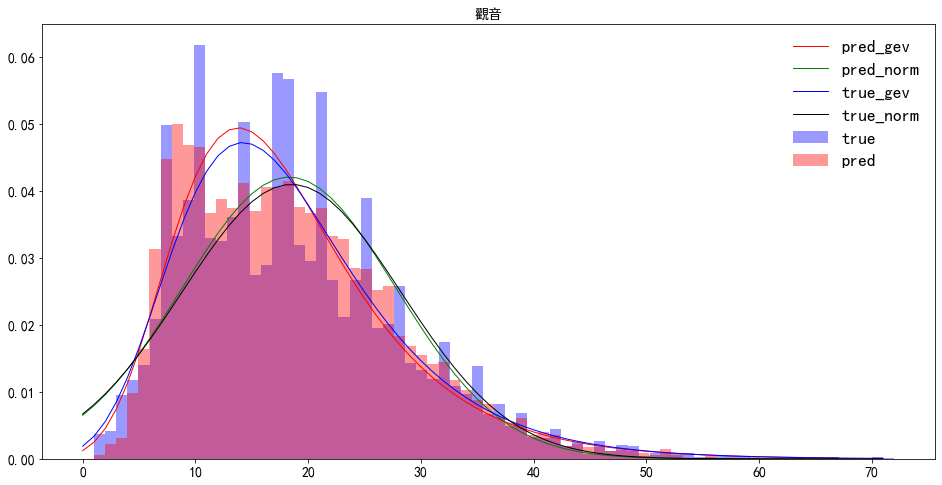

古亭
all


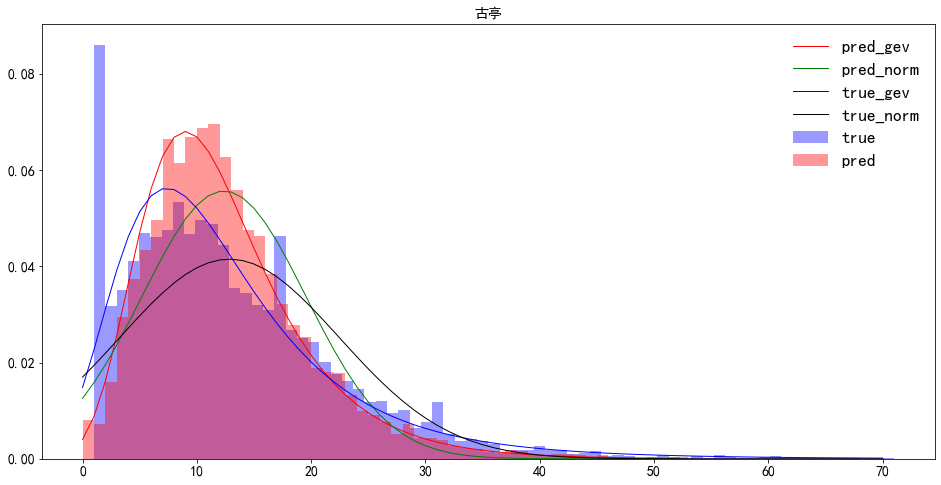

merged


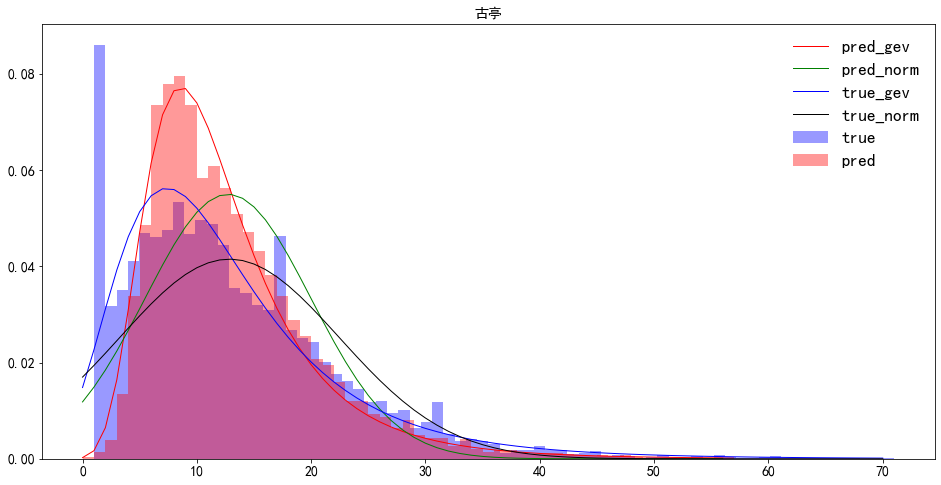

永和
all


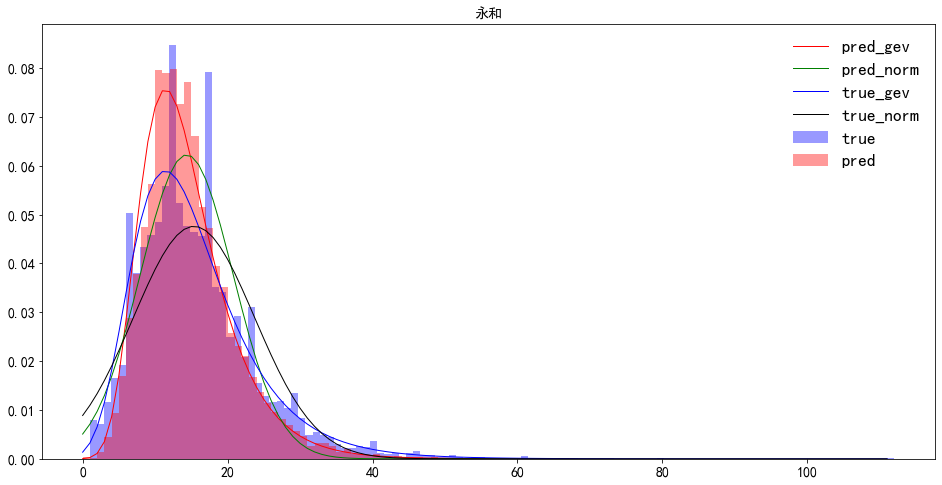

merged


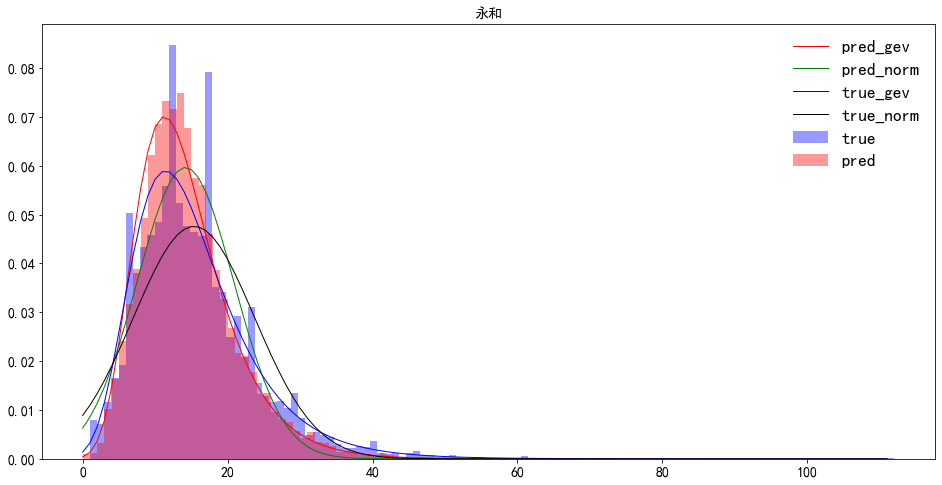

板橋
all


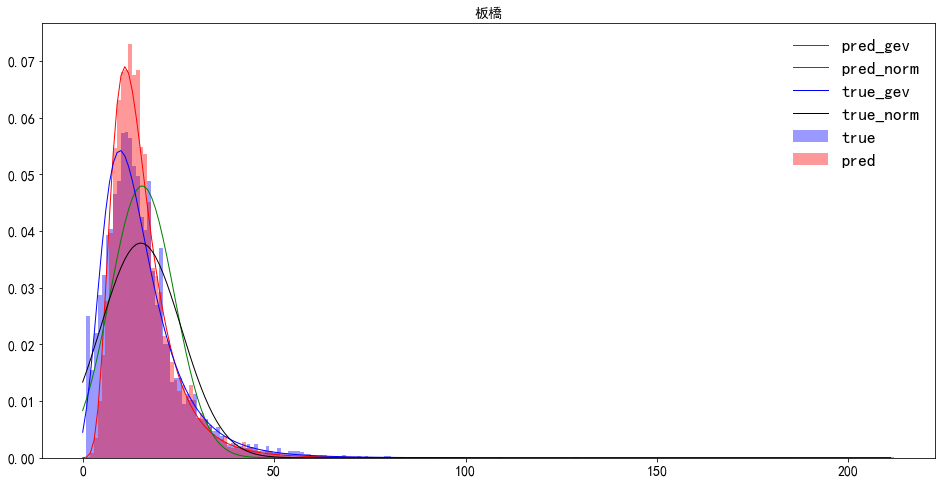

merged


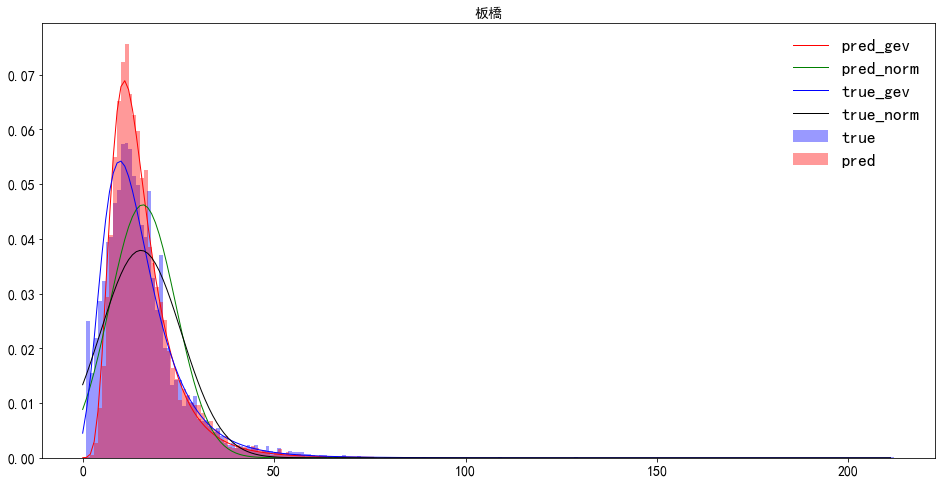

土城
all


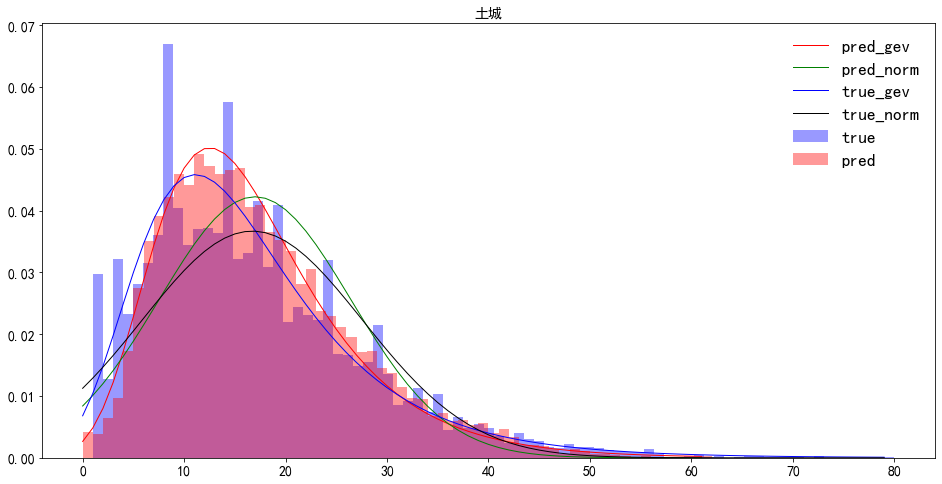

merged


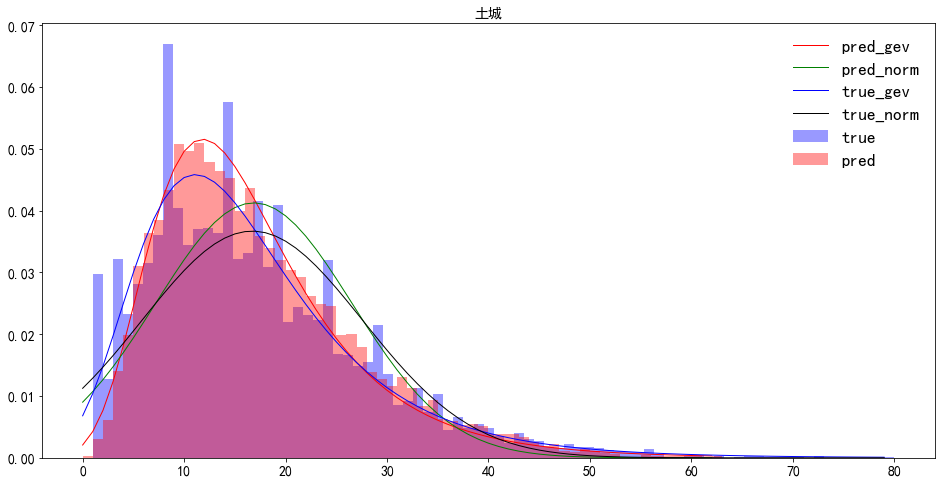

新店
all


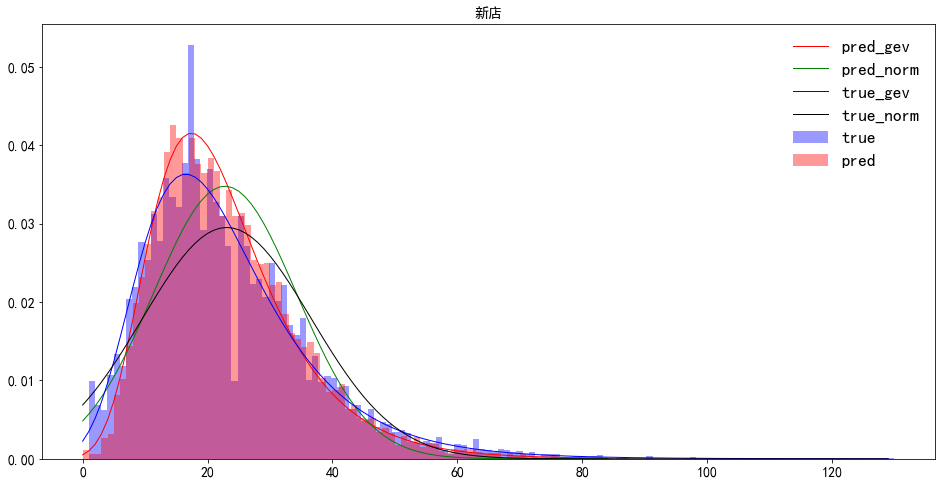

merged


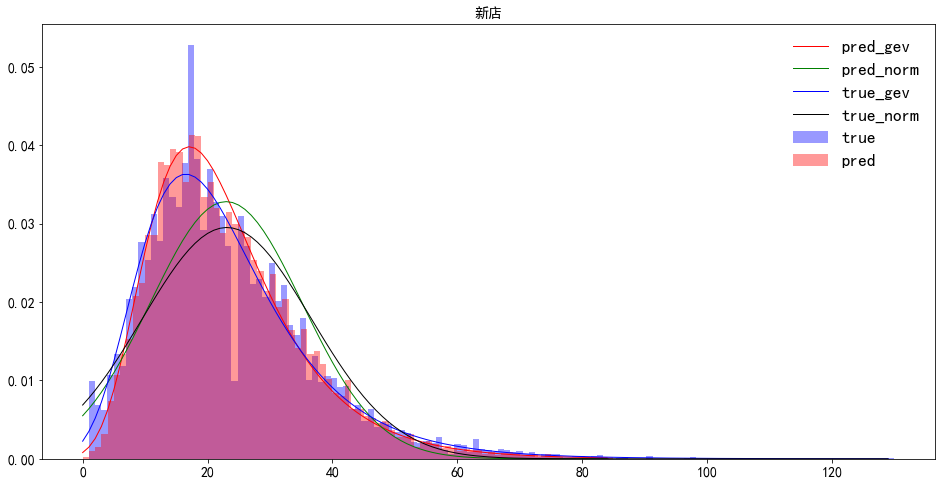

In [3]:
no = 44
origin_path = "data/origin/valid"
all_path    = f"split_method/results/{no}_all"
mgd_path = f"split_method/results/{no}_merged"
thres_path  = "data/thres/valid"
source_size = 24
target_size = 2
def plot(sitename, all_path, mgd_path):
    all_pred = np.load(f"{all_path}/{sitename}.npy")
    mgd_pred = np.load(f"{mgd_path}/{sitename}.npy")
    true     = np.load(f"{origin_path}/{sitename}.npy")
    
    thres = np.load(f"{thres_path}/{sitename}.npy")
    true = true[source_size+target_size:, 7:8]
    st = 0
    ed = 24 * 30 * 1
    all_pred = all_pred[st:ed]
    mgd_pred = mgd_pred[st:ed]
    true     = true[st:ed]
    thres    = thres[st:ed]
    x = np.arange(true.shape[0])
    
    fig, ax = plt.subplots(1, 1, figsize=(32,8))
    ax.plot(x, all_pred,    color='red',   lw=1,  label='all pred')
    ax.plot(x, mgd_pred,    color='green', lw=1,  label='merged pred')
    ax.plot(x, true,        color='blue',  lw=1,  label='true')
    ax.plot(x, thres,       color='black', lw=1,  alpha=.5, label='thres')
    ax.legend(loc='best', frameon=False, fontsize='xx-large')
    
    plt.title(f"{sitename}", fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.show()

def hist(sitename, all_path, mgd_path):
    all_pred = np.load(f"{all_path}/{sitename}.npy").astype(np.int)
    mgd_pred = np.load(f"{mgd_path}/{sitename}.npy").astype(np.int)
    true     = np.load(f"{origin_path}/{sitename}.npy").astype(np.int)
    
    true = true[source_size+target_size:, 7:8]
    all_pred[all_pred<0] = 0
    mgd_pred[mgd_pred<0] = 0
    true[true<0] = 0
    
    pred_x = np.arange(pred.max())
    gev_fit = gev.fit(pred)
    pred_gev = gev.pdf(pred_x, gev_fit[0], gev_fit[1], gev_fit[2])
    norm_fit = norm.fit(pred)
    pred_nor = norm.pdf(pred_x, norm_fit[0], norm_fit[1])
    
    true_x = np.arange(true.max())
    gev_fit = gev.fit(true)
    true_gev = gev.pdf(true_x, gev_fit[0], gev_fit[1], gev_fit[2])
    norm_fit = norm.fit(true)
    true_nor = norm.pdf(true_x, norm_fit[0], norm_fit[1])
    
    fig, ax = plt.subplots(1, 1, figsize=(16,8))
    
    ax.hist(true, 
        np.max(true),
        alpha=.4,
        label = 'true',
        color='blue',
        density=True,
        )
    ax.hist(pred, 
        np.max(pred),
        alpha=.4,
        label='pred',
        color='red',
        density=True,
        )
    
    ax.plot(pred_x, pred_gev, color='red', lw=1, alpha=1, label='pred_gev')
    ax.plot(pred_x, pred_nor, color='green', lw=1, alpha=1, label='pred_norm')
    ax.plot(true_x, true_gev, color='blue', lw=1, alpha=1, label='true_gev')
    ax.plot(true_x, true_nor, color='gold', lw=1, alpha=1, label='true_norm')
    
    ax.legend(loc='best', frameon=False, fontsize='xx-large')
    
    plt.title(f"{sitename}", fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.show()
    
for sitename in ['陽明','淡水','士林','中山','萬華','觀音','古亭','永和','板橋','土城','新店']:
    print(sitename)
#     print("line")
#     plot(sitename, all_path, merged_path)
    print("hist")
    hist(sitename, all_path, merged_path)
    break

陽明
196.0


<ipython-input-100-a6ff68cf26b1>:8: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0, p * np.log(p / q), 0))
<ipython-input-100-a6ff68cf26b1>:8: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0, p * np.log(p / q), 0))


norm kl=2.057e-01 loc= 18.37 scale= 13.54
gumbel_r kl=6.201e-02 loc= 12.47 scale= 9.7
gev kl=1.646e-01 shape= -0.56 loc= 8.28 scale= 9.37


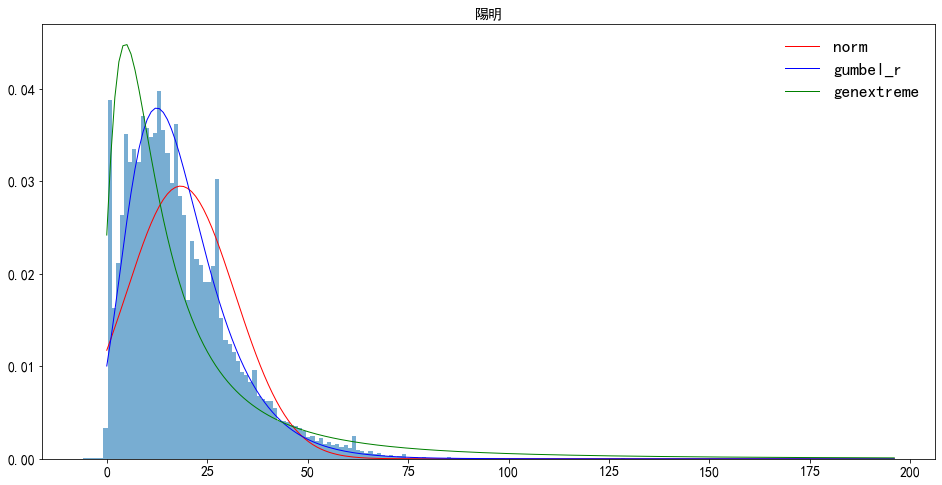

In [100]:
def gussion(x, position, width, height):
    return  height * math.sqrt(2*math.pi) * width * scipy.stats.norm.pdf(x, position, width)

def extreme(x, position, width, height, c=-0.1):
    return  height * math.sqrt(2*math.pi) * width * gev.pdf(x, c, position, width)

def kld(p, q):
    return np.sum(np.where(p != 0, p * np.log(p / q), 0))

origin_all_path = opt.origin_all_dir

for idx, sitename in enumerate(sitenames):
    
    if opt.skip_site and sitename not in sample_sites:
        continue
    print(sitename)
    read_path = os.path.join(origin_all_path, f"{sitename}.npy")
    data = np.load(read_path)[:, 7].astype(np.int)

    data[data<0] = 0
    ratio = 1
    div = 8
    max_bin = np.max(data) // ratio + 1
    
    bins = [i * ratio for i in range(max_bin)]
    hist, _ = np.histogram(data, bins=bins, density=True)
#     try:
#         zero_list = np.where(hist==0)[0]
#         max_index = zero_list[0] if zero_list[0] != 0 else zero_list[1]
#         hist = hist[:max_index]
#     except:
#         pass
# #     print(hist)
#     try:
#         pos = np.argmax(hist) * ratio
#     except:
#         print(hist)
#     if pos == 0:
#         try:
#             pos = np.argmax(hist[1:]) * ratio
#         except:
#             print(pos, hist)
#     height = np.max(hist)
#     height = np.mean(hist[hist.argsort()[-3:][::-1]])
#     width = (len(hist)-pos)/ratio/div
#     print("loc:", pos, "scale:", width, "height:", height)
    
    # Limit boundary
#     data[data>(len(hist)*2)] = 0
    max_bin = np.max(data) // ratio + 1
    bins = [i * ratio for i in range(max_bin)]
    
    # Prepare distribution
    x = np.linspace(0, np.max(data), np.max(data))
    print(np.max(x))
    
    gev_fit = gev.fit(data)
    gev_dist = gev.pdf(x, gev_fit[0], gev_fit[1], gev_fit[2])
    gev_kl = kld(hist, gev_dist)
    
    gumbel_r_fit = gumbel_r.fit(data)
    gumbel_r_dist = gumbel_r.pdf(x, gumbel_r_fit[0], gumbel_r_fit[1])
    gumbel_r_kl = kld(hist, gumbel_r_dist)
    
#     gompertz_fit = gompertz.fit(data)
#     gompertz_dist = gompertz.pdf(x, gompertz_fit[0], gompertz_fit[1], gompertz_fit[2])
#     gompertz_kl = kld(hist, gompertz_dist)
    
    norm_fit = norm.fit(data)
    norm_dist = norm.pdf(x, norm_fit[0], norm_fit[1])
    norm_kl = kld(hist, norm_dist)
    
    
    print(f'norm kl={norm_kl:.3e}'                                         ,'loc=',round(norm_fit[0],2), 'scale=',round(norm_fit[1],2))
    print(f'gumbel_r kl={gumbel_r_kl:.3e}',                                    'loc=',round(gumbel_r_fit[0],2), 'scale=',round(gumbel_r_fit[1],2))
#     print(f'gompertz kl={gompertz_kl:.3e}', 'shape=',round(gompertz_fit[0],2), 'loc=',round(gompertz_fit[1],2), 'scale=',round(gompertz_fit[2],2))
    print(f'gev kl={gev_kl:.3e}',      'shape=',round(gev_fit[0],2),      'loc=',round(gev_fit[1],2), 'scale=',round(gev_fit[2],2))
    
    
    # Plot 
    fig, ax = plt.subplots(1, 1, figsize=(16,8))
    ax.plot(x, norm_dist,    color='red', lw=1, alpha=1, label='norm')
    ax.plot(x, gumbel_r_dist,    color='blue', lw=1, alpha=1, label='gumbel_r')
#     ax.plot(x, gompertz_dist,    color='purple', lw=1, alpha=1, label='gompertz')
    ax.plot(x, gev_dist,     color='green', lw=1, alpha=1, label='genextreme')
    ax.legend(loc='best', frameon=False, fontsize='xx-large')
    
    ax.hist(data, 
            np.max(data),
#             bins=bins,
            alpha=0.6,
            density=True
            )
    plt.title(f"{sitename}", fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.show()
    break
    

8.488479331188747 5.512499931130801 4.068970026573128
lambda_1= 8.4885 lambda_2= 2.5365 lambda_3= -0.1727
tau_3= -0.0681
c= 0.0512
k= 0.4101
scale= 4.741
loc= 9.7976
loc= 11.75 scale= 9.09 shape= -0.14


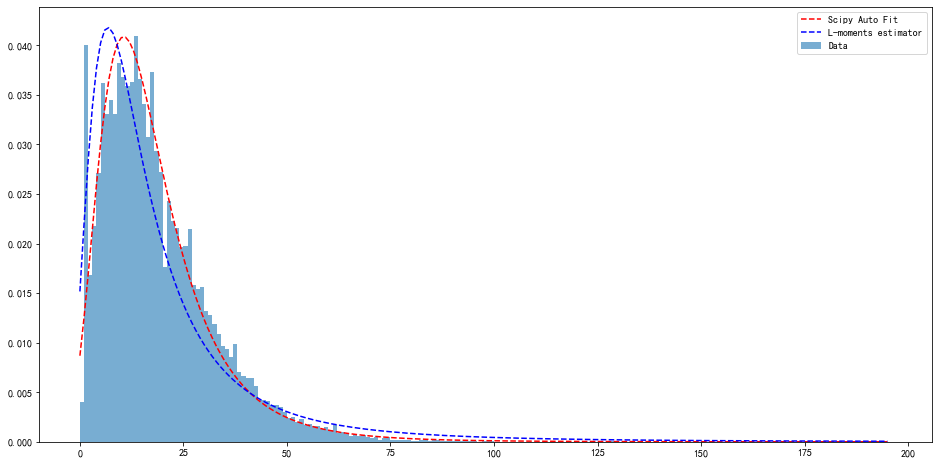

In [120]:
# 國維的 code 

def GEV(x,u,sigma,k):
    z = ((x-u)/sigma)
    distribution = (1/sigma)*(np.exp(-(1+k*z)**(-1/k)))*((1+k*z)**(-1-1/k))
    return(distribution)
def plot(x,u,sigma,k):
    xx = np.arange(np.max(x))
    gev_fit = gev.fit(x)
    gev_pdf = gev.pdf(xx, gev_fit[0], gev_fit[1], gev_fit[2])
    gev_estimator = GEV(xx,u=u,sigma=sigma,k=k)
#     gev_estimator = GEV(xx,u=gev_fit[1],sigma=gev_fit[2],k=gev_fit[0])
    print('loc=',round(gev_fit[1],2), 'scale=',round(gev_fit[2],2), 'shape=',round(gev_fit[0],2))
    plt.figure(figsize=(16,8))
    plt.hist(x, np.max(x), density=True, alpha=0.6, label='Data')
    plt.plot(xx, gev_pdf, 'r--', label='Scipy Auto Fit')
    plt.plot(xx, gev_estimator, 'b--', label='L-moments estimator')
    plt.legend()
    plt.show()

float_point = 4

sitename = "陽明"
read_path = os.path.join(origin_all_path, f"{sitename}.npy")
x = np.load(read_path)[:, 7].astype(np.int)
x[x<0] = 0

n = x.shape[0]
r = [0,1,2]
b_0=0;b_1=0;b_2=0
for i in range(n):
    b_0 = b_0+(   x[i] * ((i-r[0])/(n*(n-r[0])))   )
    b_1 = b_1+(   x[i] * ((i-r[0])*(i-r[1]))/(n*(n-r[0])*(n-r[1]))   )
    b_2 = b_2+(   x[i] * ((i-r[0])*(i-r[1])*(i-r[2]))/(n*(n-r[0])*(n-r[1])*(n-r[2]))   )
print(b_0,b_1,b_2)
lambda_1 = round(  b_0  ,float_point)
lambda_2 = round(  ((2*b_1) - b_0)  ,float_point)
lambda_3 = round(  ((6*b_2)-(6*b_1)+b_0)  ,float_point)
print('lambda_1=',lambda_1,'lambda_2=',lambda_2,'lambda_3=',lambda_3)
tau_3 = round(  lambda_3/lambda_2  ,float_point)
print('tau_3=',tau_3)
c = round(  (2/(3+tau_3)) - (np.log(2)/np.log(3))  ,float_point)
print('c=',c)
k = round(  (7.8590*c)+(2.9554* (c**2))  ,float_point)    #(7.8590*c)+(2.9554* (c**2))
print('k=',k)
a = round(    ((lambda_2*k) / ((1-(2**-k)) * float(gamma(1+k))))   ,float_point)
print('scale=',a)
xi = round(    lambda_1 - ((a/k)*(float(gamma(1+k)-1)))   ,float_point)
print('loc=',xi)
plot(x,u=xi,sigma=a*2,k=k)
#Gumbel's type I (k=0), Frechet's type II (k<0), Weibull or type III (k>0)
#x = np.arange(35)
#for k not equal 0 , x < xi + (a/k)
#gev_cdf = np.exp(-((1-(k*((x-xi)/a)))**(1/k)))